In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sys
sys.path.append("../../.")

#from ccmodels.analysis.utils import tuning_encoder
import ccmodels.dataanalysis.utils as utl 
import ccmodels.modelanalysis.utils as mutl 

import ccmodels.dataanalysis.statistics_extraction as ste 
import ccmodels.utils.angleutils as au

import ccmodels.plotting.styles as sty 
import ccmodels.plotting.color_reference as cr
import cmasher as cmr
import ccmodels.plotting.utils as plotutils

import ccmodels.modelanalysis.model as md

import ccmodels.modelanalysis.currents as mcur
import ccmodels.dataanalysis.currents as curr
import ccmodels.dataanalysis.processedloader as loader
import ccmodels.dataanalysis.filters as fl


Palette 'Egypt' has '4' discrete colors


ModuleNotFoundError: No module named 'ccmodels.modelanalysis.functions'

# Some preliminaries 

In [ ]:
path2save = 'talkfigures'
prepath = '../../data' 
style = 'slides'
software = 'powerpoint'
sty.master_format(style=style)

# Approach motivation

These are obtained almost directly from Alessandro's notebook

['direction' 'not_matched' 'not_selective' 'orientation']
['not_matched' 'not_selective' 'selective']


/tmp/ipykernel_6600/1799614548.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V


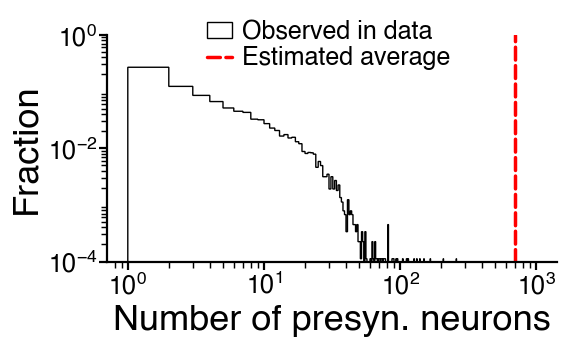

In [178]:
path_to_folder=f"{prepath}/preprocessed/"
activity_table = pd.read_csv(path_to_folder+"activity_table.csv")
connections_table = pd.read_csv(path_to_folder+"connections_table.csv")
unit_table= pd.read_csv(path_to_folder+"unit_table.csv")


# put pref orientation of not-selective neurons to nan
mask_not_selective=(unit_table['tuning_type']=='not_selective')
unit_table.loc[mask_not_selective, 'pref_ori'] = np.nan
# focus on orientation, take preferred orientation mod pi
unit_table.loc[:,'pref_ori']=np.mod(unit_table.loc[:,'pref_ori'],8)
activity_table.loc[:,'angle_shown']=np.mod(activity_table.loc[:,'angle_shown'],8)

print(np.unique(unit_table['tuning_type']))
mask_selective=(unit_table['tuning_type']=='orientation')|(unit_table['tuning_type']=='direction')
unit_table.loc[mask_selective, 'tuning_type'] ='selective'
print(np.unique(unit_table['tuning_type']))


# remove self-connection
connections_table=connections_table[connections_table['pre_pt_root_id']!= connections_table['post_pt_root_id']]
# normalize synaptic volumes with respect to average E -E connection strength
norm_V=fun.Compute_normalization_factor_for_synaptic_volume(connections_table, unit_table)
connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V


# Filter unit_table to consider only rows where axon_proof is not 'non'
filtered_unit_table = unit_table[unit_table['axon_proof'] != 'non']

# Join connections_table with filtered_unit_table on pre_pt_root_id and pt_root_id
merged_table = pd.merge(connections_table, filtered_unit_table, left_on='pre_pt_root_id', right_on='pt_root_id', how='inner')

# Group by post_pt_root_id and count unique pre_pt_root_id values for each group
pre_pt_count_per_post = merged_table.groupby('post_pt_root_id')['pre_pt_root_id'].nunique().reset_index()
pre_pt_count_per_post.columns = ['post_pt_root_id', 'pre_pt_count']


figsize = {'slides':sty.slide_size(0.5, 0.75, software=software), 'poster':sty.to_inches(np.array([14.1, 8.5]))} 

fig=plt.figure(figsize=figsize[style], layout='constrained')  # Set figure size

plt.hist(pre_pt_count_per_post['pre_pt_count'].values,np.arange(0,10**3,1),density=True,histtype='step',color='k',label='Observed in data')
plt.axvline(x=700,ls='--',color='r',label='Estimated average')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(0, 0.25)
#plt.title('Predicted preferred orientation\n(data shifted so that correct answer is 0)', fontsize=16)
plt.xlabel(r'Number of presyn. neurons')
plt.ylabel(r'Fraction')
plt.legend(loc=(0.2, 0.8))

plt.yticks([1e-4, 1e-2, 1e-0])
plt.ylim(1e-4, 1.0)

# Save or show plot
plt.show()
#fig.set_size_inches(1.875,1.875*rows)
pic_name=f'{path2save}/indegree.pdf'
fig.savefig(pic_name,format='pdf', transparent=True)

In [14]:

# load files
path_to_folder=f"{prepath}/preprocessed/"
connections_table = pd.read_csv(path_to_folder+"connections_table.csv")
unit_table= pd.read_csv(path_to_folder+"unit_table.csv")

# remove selectivity
unit_table.loc[:, 'pref_ori'] = np.nan
unit_table.loc[:, 'tuning_type'] ='not_selective'

# remove self-connection
connections_table=connections_table[connections_table['pre_pt_root_id']!= connections_table['post_pt_root_id']]


# List of all the possible labels neurons can have: areas, layer,  cell type, and tuning type
Labels = []
for area in ['V1']:
    for layer in ['L23', 'L4']:
        possible_cell_type = ['exc', 'inh'] if layer == 'L23' else ['exc']
        for cell_type in possible_cell_type:
            for tuning_type in ['selective','not_selective']:
                mask_cell_type = (unit_table['cell_type'] == cell_type) & (unit_table['layer'] == layer)
    
                label_info = {'area': area,
                              'layer': layer,
                              'cell_type': cell_type,
                              'tuning_type':tuning_type
                             }
                # Append label information to Labels
                Labels.append(label_info)

cases=[
       [['non',],['non',]],
       [['clean'],['clean']],
       [['extended'],['extended'],],
        [['non','clean','extended'],['clean','extended']],
      ]
Labels_legend=[r'non$\leftarrow$non',
        r'clean$\leftarrow$clean',
        r'extnd$\leftarrow$extnd',
        r'all$\leftarrow$clean/extn',
       ]


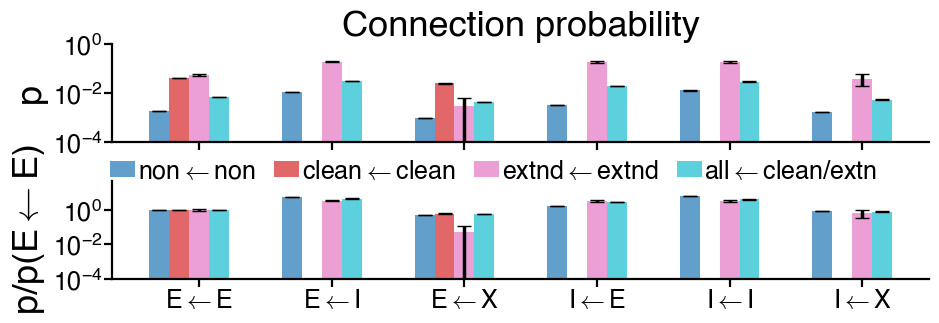

In [17]:

from itertools import product

def plot_all_cases(connections_table, unit_table, Labels, cases, Labels_legend):
    nrows, ncols = 2, 1

    figsize = {'slides':sty.slide_size(0.45, 0.75, software=software), 'poster':sty.to_inches([24.7, 8.47])}

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize[style])
    
    x_labels = []
    label_indices = {}
    colors = plt.cm.tab10(np.linspace(0, 1, len(cases)))

    #axs[0].set_title('Connection probability between neuron types\n measured for different proofreading status')
    axs[0].set_title('Connection probability')

    axs[0].set_ylabel('p')
    axs[1].set_ylabel(r'p/p(E$\leftarrow$E)')

    count = 0
    bar_width = 0.15  # Width of the bars

    for idx_case, (post_proof_status, pre_proof_status) in enumerate(cases):
        # Measure connection stats (assuming this is a function in your code)
        Conn_stat_measured_on_data = fun.measure_connection_stats_plotting(connections_table, unit_table, Labels, post_proof_status, pre_proof_status)
        
        # Calculate the total sum of prob_conn[0] for normalization
        total_prob_conn = sum(
            Conn_stat_measured_on_data[(tuple(sorted(label_post.items())), tuple(sorted(label_pre.items())))]
            ['prob_conn'][0]
            for label_post, label_pre in product([Labels[1]], [Labels[1]])
        )

        for label_post, label_pre in product([Labels[1], Labels[3]], [Labels[1], Labels[3], Labels[5]]):
            label_key_post = tuple(sorted(label_post.items()))
            label_key_pre = tuple(sorted(label_pre.items()))

            # Extract label information
            layer_post, cell_type_post, tuning_post = label_post['layer'], label_post['cell_type'], label_post['tuning_type']
            layer_pre, cell_type_pre, tuning_pre = label_pre['layer'], label_pre['cell_type'], label_pre['tuning_type']
            
            # Construct label display
            #label_display = fr"{layer_post}{cell_type_post}$\leftarrow${layer_pre}{cell_type_pre}"
            postlabel = ''
            if cell_type_post=='exc':
                postlabel = 'E' if layer_post=='L23' else 'X'
            else:
                postlabel = 'I'
            prelabel = ''
            if cell_type_pre =='exc':
                prelabel= 'E' if layer_pre=='L23' else 'X'
            else:
                prelabel = 'I'
                
            label_display = fr"{postlabel}$\leftarrow${prelabel}"
            
            if label_display not in label_indices:
                label_indices[label_display] = count
                x_labels.append(label_display)
                count += 1
            
            index = label_indices[label_display] + idx_case * bar_width - (len(cases) * bar_width) / 2

            prob_conn = Conn_stat_measured_on_data[(label_key_post, label_key_pre)]['prob_conn']
            normalized_prob_conn = prob_conn[0] / total_prob_conn

            axs[0].bar(index, prob_conn[0], bar_width, yerr=prob_conn[1], capsize=5, 
                       label=Labels_legend[idx_case] if label_indices[label_display] == count - 1 else "", 
                       alpha=0.7, color=colors[idx_case])
            axs[1].bar(index, normalized_prob_conn, bar_width, yerr=prob_conn[1] / total_prob_conn, capsize=5, 
                       label=Labels_legend[idx_case] if label_indices[label_display] == count - 1 else "", 
                       alpha=0.7, color=colors[idx_case])

    # Set x-axis ticks and labels for the plot
    axs[0].set_xticks(np.arange(len(x_labels)))
    axs[0].set_xticklabels([])

    axs[1].set_xticks(np.arange(len(x_labels)))
    axs[1].set_xticklabels(x_labels, rotation=45, ha='right')

    for ax in axs:
        ax.set_yscale('log')
    axs[0].set_ylim([0.0001, 0.5])
    axs[1].set_ylim([0.01, 50])

    # Only show one legend entry per case
    handles, labels = axs[0].get_legend_handles_labels()
    unique_labels = {label: handle for handle, label in zip(handles, labels)}
    
    # Place legend outside the plot
    #axs[1].legend(unique_labels.values(), unique_labels.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

    if style=='slides':
        axs[1].legend(unique_labels.values(), unique_labels.keys(), loc=('center left'), ncols=2, bbox_to_anchor=(0, 1.1))
    else:
        axs[1].legend(unique_labels.values(), unique_labels.keys(), loc=('center left'), ncols=4, bbox_to_anchor=(-0.03, 1.1), handletextpad=0.1, columnspacing=0.75)
        axs[0].set_yticks([1e-4, 1e-2, 1])
        axs[1].set_yticks([1e-4, 1e-2, 1])
        axs[1].set_xticklabels(x_labels, rotation=0, ha='center')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)  # Adjust right space to fit the legend
    # Save or show plot
    #fig.set_size_inches(1.875,1.875*rows)
    pic_name=f'{path2save}/conn_prob_type_proofread.pdf'
    fig.savefig(pic_name,format='pdf', dpi=300, transparent=True)
    plt.show()

# Assuming fun.measure_connection_stats, connections_table, and unit_table are defined
# Plot all cases in the same figure
plot_all_cases(connections_table, unit_table, Labels, cases, Labels_legend)


['direction' 'not_matched' 'not_selective' 'orientation']
['not_matched' 'not_selective' 'selective']
Number of pre neurons: 2279 tuning type ['non']
Number of post neurons: 2279 tuning type ['non']
number of synapses=14428
Number of pre neurons: 120 tuning type ['clean']
Number of post neurons: 102 tuning type ['clean']
number of synapses=552
Number of pre neurons: 133 tuning type ['clean' 'extended' 'non']
Number of post neurons: 2412 tuning type ['clean' 'extended']
number of synapses=3137


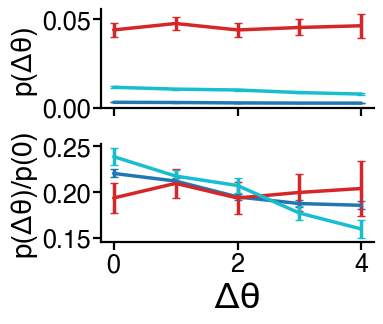

In [164]:
# load files
path_to_folder=f"{prepath}/preprocessed/"
activity_table = pd.read_csv(path_to_folder+"activity_table.csv")
connections_table = pd.read_csv(path_to_folder+"connections_table.csv")
unit_table= pd.read_csv(path_to_folder+"unit_table.csv")


# put pref orientation of not-selective neurons to nan
mask_not_selective=(unit_table['tuning_type']=='not_selective')
unit_table.loc[mask_not_selective, 'pref_ori'] = np.nan
# focus on orientation, take preferred orientation mod pi
unit_table.loc[:,'pref_ori']=np.mod(unit_table.loc[:,'pref_ori'],8)
activity_table.loc[:,'angle_shown']=np.mod(activity_table.loc[:,'angle_shown'],8)

print(np.unique(unit_table['tuning_type']))
mask_selective=(unit_table['tuning_type']=='orientation')|(unit_table['tuning_type']=='direction')
unit_table.loc[mask_selective, 'tuning_type'] ='selective'
print(np.unique(unit_table['tuning_type']))
mask_selective=unit_table['tuning_type']=='selective'

# remove self-connection
connections_table=connections_table[connections_table['pre_pt_root_id']!= connections_table['post_pt_root_id']]


figsize = {'slides':sty.slide_size(0.5, 0.75, software=software), 'poster':sty.to_inches([10, 8.5])}


nrows, ncols = 2, 1
fig, axs = plt.subplots(nrows, ncols, figsize=figsize[style], facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = axs.ravel()


colors = plt.cm.tab10(np.linspace(0, 1, len(cases)))
#for idx_cases in range(len(cases)):
for idx_cases in [0,1,3]: 
    post_proof_status=cases[idx_cases][0]
    pre_proof_status=cases[idx_cases][1]


    # Filter specific to post neurons
    mask_selective = unit_table['tuning_type']== 'selective'
    mask_post = mask_selective & (unit_table['cell_type'] == 'exc') & (unit_table['layer'] == 'L23')
    mask_post &= unit_table['dendr_proof'].isin(post_proof_status)
    
    post_neurons = unit_table[mask_post]

    # Filter specific to pre neurons
    mask_pre = mask_selective & (unit_table['cell_type'] == 'exc') & (unit_table['layer'] == 'L23')
    mask_pre &= unit_table['axon_proof'].isin(pre_proof_status)
    pre_neurons = unit_table[mask_pre]

    print(f"Number of pre neurons: {len(pre_neurons)}",'tuning type',np.unique(post_neurons['dendr_proof']))
    print(f"Number of post neurons: {len(post_neurons)}",'tuning type',np.unique(pre_neurons['axon_proof']))


    post_id_list=post_neurons['pt_root_id'].values
    pre_id_list=pre_neurons['pt_root_id'].values
    mask_all=connections_table['pre_pt_root_id'].isin(pre_id_list)& connections_table['post_pt_root_id'].isin(post_id_list)
    
    print('number of synapses=%d'%len(connections_table[mask_all]))
          
    dist_measured, Pd_measured, _ = fun.measure_P_of_dist_ell(post_neurons, pre_neurons, connections_table)

    # Calculate mean and standard deviation over bootstrap samples
    mean_Pd_measured = Pd_measured[:,0]
    std_Pd_measured = Pd_measured[:,1]
    mean_Pd_measured_normalized = mean_Pd_measured/np.sum(mean_Pd_measured)
    std_Pd_measured_normalized = std_Pd_measured/np.sum(mean_Pd_measured)


    ax[0].errorbar(dist_measured, mean_Pd_measured, yerr=std_Pd_measured,color=colors[idx_cases])
    ax[1].errorbar(dist_measured, mean_Pd_measured_normalized, yerr=std_Pd_measured_normalized,color=colors[idx_cases],label=Labels_legend[idx_cases]+', \n#synapses=%d'%len(connections_table[mask_all]))

if style=='slides':
    axs[0].set_title('Conn. prob. among tuned neurons')
    axs[0].set_ylabel('p(Δθ)')
    axs[1].set_ylabel('p(Δθ)/p(0)')
else:
    axs[0].set_ylabel('p(Δθ)', fontsize=20)
    axs[1].set_ylabel('p(Δθ)/p(0)', fontsize=20)


axs[1].set_xlabel(r'Δθ')
# Place legend outside the plot
#axs[1].legend( loc='center left', bbox_to_anchor=(0, 1.1), ncols=2)

plt.subplots_adjust(hspace=0.4)

# Assuming fun.measure_connection_stats, connections_table, and unit_table
#for ax in axs:
#    ax.set_yscale('log')
# Display legend
#for ax in axs:
#    ax.legend()

plt.tight_layout()

pic_name=f'{path2save}/conn_prob_tuned_proofread.pdf'
fig.savefig(pic_name,format='pdf', transparent=True)

plt.show()


# Statistics extraction

In [19]:
import fig2

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


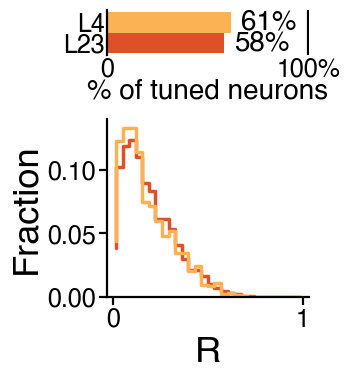

In [22]:
orientation_only = True 
v1_neurons, v1_connections, rates = loader.load_data(orientation_only=orientation_only, prepath=prepath)

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches([9.17, 9.87])}
fig, axes = plt.subplots(nrows=2, ncols=1, height_ratios=[0.25, 1], figsize=figsize[style])

#Se we can easily filter synapses by the layer in which the presynaptic neuron lives directly
#without having to call .isin(...) all the time.
#Adds two extra columns to v1_connections
v1_connections = utl.add_layerinfo_to_connections(v1_neurons, v1_connections, who="pre") 

#For many things in this figure we need only the functionally matched neurons, the others are not useful
matched_neurons = fl.filter_neurons(v1_neurons, tuning="matched")
matched_connections = fl.synapses_by_id(v1_connections, pre_ids=matched_neurons["id"], post_ids=matched_neurons["id"], who="both")

# --- First panel

#Plot the data for both layer in the same axis. Then format it. 
fig2.fraction_tuned(axes[0], matched_neurons, fstitle=20)

#Plot the data for both layer in the same axis. Then format it. 
ax = axes[1]
#Create bins and compute their centers, which is useful for plotting
bins = np.linspace(0, 1, 30)
bins_centered = 0.5*(bins[1:] + bins[:-1])
for layer in ['L23', 'L4']:
    tuned_neurons = fl.filter_neurons(v1_neurons, tuning="tuned", layer=layer)
    ratestuned = rates[tuned_neurons['id']]
    cv = mutl.compute_circular_variance(ratestuned, orionly=True)

    #Histogram them, normalizing to count (not by density) 
    hist, _ = np.histogram(cv, bins)
    hist = hist/np.sum(hist)
    ax.step(bins_centered, hist, color = cr.lcolor[layer])



fig.subplots_adjust(hspace=0.4)

axes[1].set_facecolor('#00000000')

#Nice labels
ax.set_ylabel('Fraction')
ax.set_xlabel('R')
ax.set_ylim(bottom = 0)

plt.tight_layout()
pic_name=f'{path2save}/tuningdistribution.pdf'
fig.savefig(pic_name,format='pdf', transparent=True)

plt.show()


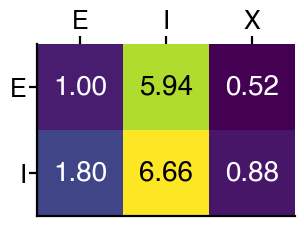

In [154]:
pcon = pd.read_csv('../../data/model/prob_connectomics.csv')[['E', 'I', 'X']]
norma = pcon.iloc[0,0]

figsize = {'slides':sty.slide_size(0.5, 0.3, software), 'poster':sty.to_inches(np.array([10, 6]))}
plt.figure(figsize=figsize[style])
plt.imshow(pcon.values, interpolation="none")

#Plot the text inside of the matrix
for (j,i),value in np.ndenumerate(pcon.values):
    color = "black" if value/norma > 4 else "white"
    plt.text(i, j, f"{value/norma:.2f}", ha="center",va="center", color=color, fontsize=20)

#Beautiful ticks and so on...
plt.yticks([0,1], labels=pcon.columns[:2])
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)


plt.xticks([0,1,2], labels=pcon.columns)

pic_name=f'{path2save}/probconnections.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)

plt.show()

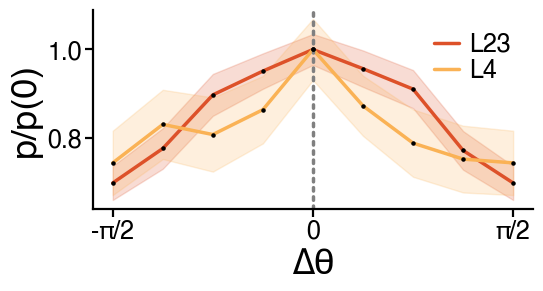

In [117]:
figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches([13.5, 7.1])}
fig= plt.figure(figsize=figsize[style], layout='constrained')

#Probability as a function of the dtheta
fig2.conn_prob_osi(plt.gca(), matched_neurons, matched_connections, half=True)

pic_name=f'{path2save}/probconnections_angle.pdf'

fig.savefig(pic_name,format='pdf', transparent=True)


# Let's plot some currents

In [6]:
import fig3

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")
/tmp/ipykernel_4998/2267533989.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.24530988 2.38714996 0.46813719 ... 3.6067048  1.62424121 0.74492268]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections.loc[:, 'syn_volume'] /=  connections.loc[:, 'syn_volume'].mean()


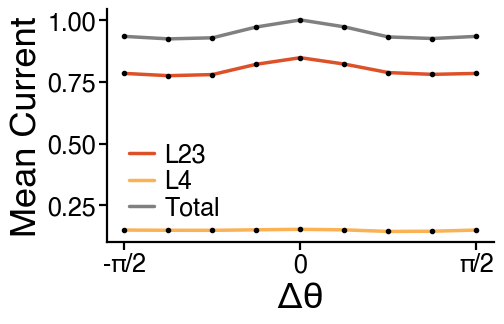

In [5]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
connections = fl.remove_autapses(connections)

connections.loc[:, 'syn_volume'] /=  connections.loc[:, 'syn_volume'].mean()

matchedunits = fl.filter_neurons(units, tuning='matched')
matchedconnections = fl.synapses_by_id(connections, pre_ids=matchedunits['id'], post_ids=matchedunits['id'], who='both')

vij = loader.get_adjacency_matrix(matchedunits, matchedconnections)


figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12.7, 8.5]))}
plt.figure(figsize=figsize[style])

currents = mcur.bootstrap_mean_current(units, vij, rates)
totalmean = currents['Total'].mean(axis=0).max()

for layer in ['L23', 'L4', 'Total']:
    plt.plot(plotutils.shift(currents[layer].mean(axis=0)/totalmean), label=layer, color=cr.lcolor[layer])
    plt.plot(plotutils.shift(currents[layer].mean(axis=0)/totalmean), color="black", marker='.', ls="none") 

plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.ylabel("Mean Current")
plt.xlabel("Δθ")
plt.legend()

pic_name=f'{path2save}/datameancurrents.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', dpi=300, transparent=True)

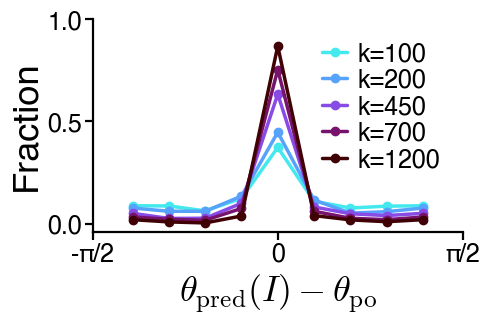

In [21]:
figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12.7, 8.5]))}
plt.figure(figsize=figsize[style])

orientation_only = True
angles = plotutils.get_angles(kind="centered", half=orientation_only)
tuned_outputs = fl.filter_connections(matched_neurons, matched_connections, tuning="matched", who="pre") 

nexperiments = 1000

cmap = cmr.gem_r
klist = [100, 200, 450, 700, 1200]

for i,k in enumerate(klist):
    prob_pref_ori  = curr.sample_prefori(matched_neurons, tuned_outputs, nexperiments, rates, nsamples=k)
    plt.plot(angles, plotutils.shift(prob_pref_ori), label=f"k={k}", color=cmap(i/(len(klist)-1)), marker='o')

plt.xticks([-2,0,2], ['-π/2', '0', 'π/2'])
plt.yticks([0, 0.5, 1])
plt.xlabel(r"$\theta_\text{pred}(I) - \theta_\text{po}$")
plt.ylabel("Fraction")
plt.legend(loc='best')

pic_name=f'{path2save}/preforiselected.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', dpi=300, transparent=True)
plt.show()

# Model best parameters and comparison

In [22]:
import ccmodels.modelanalysis.inference as sbinf
from KDEpy import FFTKDE

In [35]:
def plot_posterior_distrib(axes, posterior_samples, intervals, inferred, cmap=None, lw=2.0, bw='ISJ', fs=20):
    """
    Plot a graph representing the posterior distribution for each parameter.
    Parameters
    ==========
    - axes : matploblib axes ndarray
        An array containing the axes where to plot it.
    - posterior_samples : ndarray
        The array containing the set of samples to be histogrammed, for each parameter. NparxNdata
    - intervals : ndarray
        Contains the [xmin, xmax] for each one of the parameters. 
    - correct_pars, inferred : ndarray
        The arrays containing ground truth and the inferred parameters, respectively
    - fitting_eqs : string
        Fitting model we are currently employing. Sets x labels. 
    """

    #Plot with a different colormap to differentiate from rel error plots
    if cmap is None:
        cmap = cmr.amber
    color = cmap(0.6)
    colorline = cmap(0.3)

    labels = ["J", "g", "Vth", "σ", "τI"]

    #A plot for each parameter
    for param in range(axes.size):

        #Histogram
        bins = np.linspace(intervals[param][0], intervals[param][1], 100)
        hist, edges = np.histogram(posterior_samples[:,param], bins=bins, density=True)
        centered = 0.5*(edges[1:]+edges[:-1])
        
        x, y = FFTKDE(kernel='gaussian', bw=bw).fit(posterior_samples[:,param].numpy()).evaluate()
        #Fill between for fancyness
        #axes[param].fill_between(centered, np.zeros(99), hist, color=color, lw=2.0, alpha=0.5)
        axes[param].fill_between(x, np.zeros(len(x)), y, color=color, lw=2.0, alpha=0.5)

        #Now highlight correct and most common (estimation)
        axes[param].axvline(inferred[param], c=colorline, ls="--", lw=lw)
        
        
        #Despine and clean axes
        axes[param].spines['right'].set_visible(False)
        axes[param].spines['top'].set_visible(False)
        axes[param].set_yticks([])
        axes[param].set_ylim(0, 1.1*np.max(hist))

        #Set labels
        axes[param].set_xlabel(labels[param])


    #Finish graph
    axes[0].set_ylabel("Prob. density", fontsize=fs)
    return

In [25]:
units, connections, rates = loader.load_data(orientation_only=True, prepath='../../data/') 

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
osi_e = mutl.compute_orientation_selectivity_index(rates[units_e['id']])
rates_e = rates[units_e['id']]

cveo, cved = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

#lucky
summary_data = torch.tensor([rates_e.mean(), rates_e.std(), cved.mean(), cved.std(), 0.0])
summary_data

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


tensor([1.6706, 2.9155, 0.2343, 0.1361, 0.0000], dtype=torch.float64)

In [26]:
j_int = [0,5]
g_int = [1,5]
th_int = [10,25]
s_int = [1,15]
prior, prior_space, intervals = sbinf.prepare_priors(j_int, g_int, th_int, s_int)

In [27]:
posterior = sbinf.load_network(f'{prepath}/model/k400_WORKING.pkl')
posterior_samples = posterior.sample((1000000,), x=summary_data.float())

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples: 1001284it [00:05, 185579.69it/s]                            


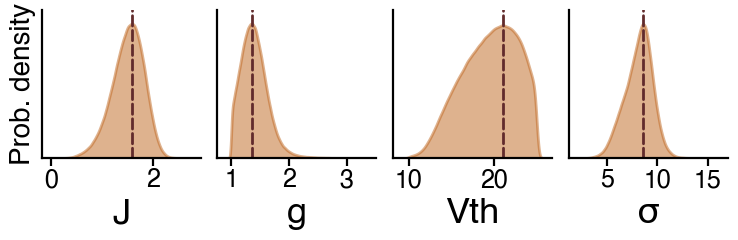

In [36]:
ncols = 4 

figsize = {'slides':sty.slide_size(0.5, 0.4, software), 'poster':sty.to_inches(np.array([19.0, 6.35]))}

bw = 'silverman'
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=figsize[style])

inferred = sbinf.get_estimation_parameters_KDE(posterior_samples, bw=bw).numpy()
if style=='poster':
    plot_posterior_distrib(axes, posterior_samples, intervals, inferred, bw=bw, fs=20)
else:
    plot_posterior_distrib(axes, posterior_samples, intervals, inferred, bw=bw)
fig.tight_layout()

pic_name=f'{path2save}/posteriors.pdf'
fig.savefig(pic_name,format='pdf', transparent=True)

plt.show()

# Get a simulation where L4 is dominant

We search for a random seed where this happens.

In [68]:
orionly= True
local_connectivity =False 

np.random.seed(49586971)
inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, rx, stdre, units_sample, connections_sample, QJ, n_neurons, original_tuned_ids, original_prefori = md.make_simulation(400, 8000, inferred[0], inferred[1],  theta=inferred[2], sigma_t=inferred[3], local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/matrixsampler.py:235: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  act_matrix[i,theta] = activity_L4.loc[i, theta]
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  th

1.6706474129595197 1.3870917081793577
1.4698833218887826 1.4670380743447529


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


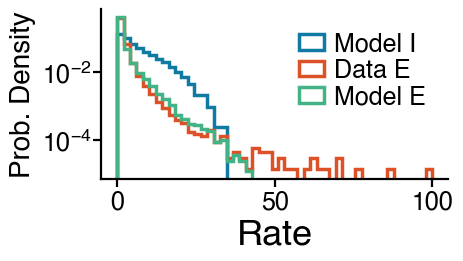

In [69]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.xlabel('Rate')
if style=='poster':
    plt.ylabel('Prob. Density', fontsize=20)
else:
    plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_L4.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)

plt.show()


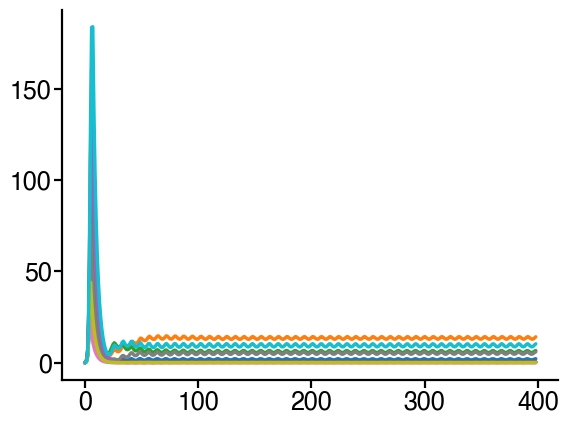

In [70]:
for i in range(10):
    plt.plot(aE_t[i, :])

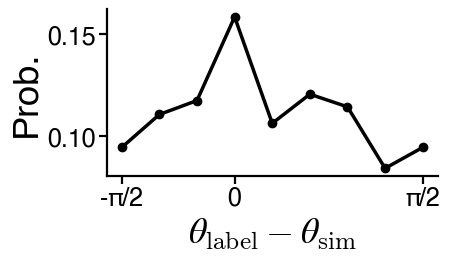

In [71]:
newpreforis = units_sample[units_sample['id'].isin(original_tuned_ids)] 
angledif = au.signed_angle_dist_vectorized(newpreforis['pref_ori'].values, original_prefori.values, half=True)

bins = np.arange(-3.5, 6.5, 1)
#bins = np.arange(-0.5, 16.5, 1)
hist, edges = np.histogram(angledif, bins=bins)
hist[-1] = hist[0]
cedges = 0.5*(edges[1:]+edges[:-1])
figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])
plt.plot(cedges,  hist / hist.sum(), marker='o', color='black')
plt.xticks([-3,0,5], ['-π/2', '0', 'π/2'])
plt.xlabel(r"$θ_\text{label} - θ_\text{sim}$")
plt.ylabel("Prob.")
pic_name=f'{path2save}/angleschanged_L4.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

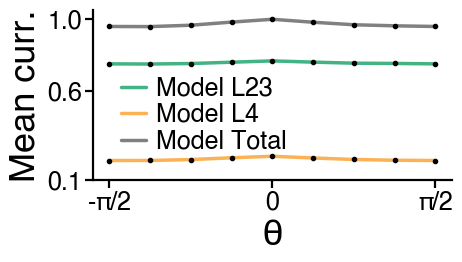

In [72]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.yticks([0.1, 0.6, 1])
plt.ylim(0.1, 1.05)
plt.legend(loc = (0.05, 0.1))

plt.xlabel('θ')
plt.ylabel('Mean curr.')
pic_name=f'{path2save}/modelcurrents_L4.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


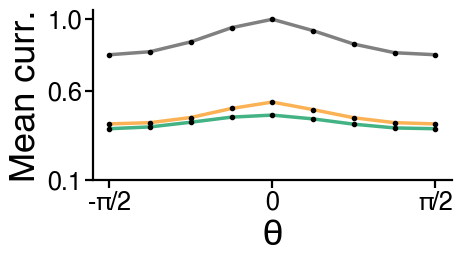

In [74]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['tuned', 'tuned'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.2))
plt.yticks([0.1, 0.6, 1])
plt.ylim(0.1, 1.05)

plt.xlabel('θ')
plt.ylabel('Mean curr.')
pic_name=f'{path2save}/modelcurrentstuned_L4.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

0.3853354845814142


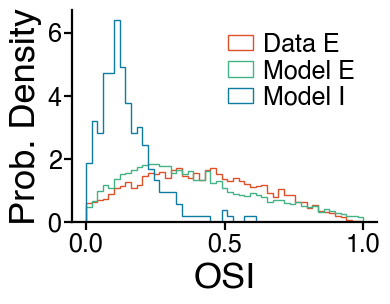

In [52]:
bins = np.linspace(0,1,50)

OSI_E = mutl.compute_orientation_selectivity_index(re)    
OSI_I = mutl.compute_orientation_selectivity_index(ri)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
osi_data = mutl.compute_orientation_selectivity_index(rates[units_e['id']])

print(OSI_E.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(osi_data, bins=bins, density=True,  histtype='step', label="Data E", color=cr.lcolor['L23'])
plt.hist(OSI_E, bins=bins, density=True, histtype='step', label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(OSI_I, bins=bins, density=True, histtype='step', label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("OSI")
plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelosi_L4.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

0.23431331378920173 0.23216795781466346


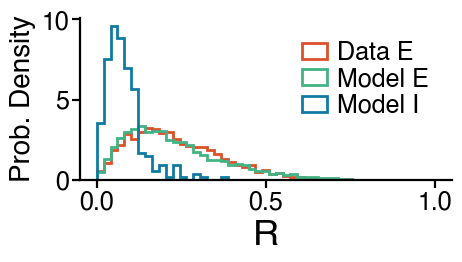

In [53]:
bins = np.linspace(0,1,50)

cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), cved.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True, histtype='step', lw=2, label="Data E", color=cr.lcolor['L23'])
plt.hist(cved, bins=bins, density=True, histtype='step', lw=2, label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(cvid, bins=bins, density=True, histtype='step', lw=2, label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
if style=='poster':
    plt.ylabel("Prob. Density", fontsize=20)
else:
    plt.ylabel("Prob. Density")
plt.legend()
plt.tight_layout()
pic_name=f'{path2save}/modelcirvar_L4.pdf'
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

## Reshuffling experiments for this network

In [ ]:

orionly= True
local_connectivity =False 

inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, stdre, units_sample = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='alltuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scpint.quad(integrand, min, max)
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achiev

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


1.6706474129595197 1.5096337044065802
1.4698833218887826 1.4670380743447529


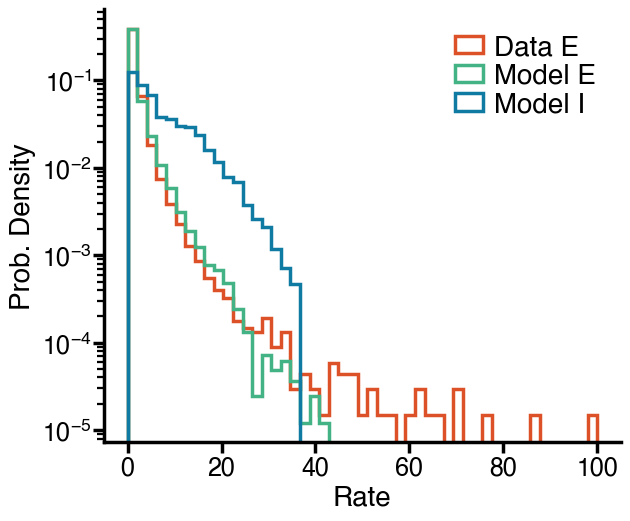

In [ ]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.xlabel('Rate')
plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_reshuffALL_L4.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')

plt.show()


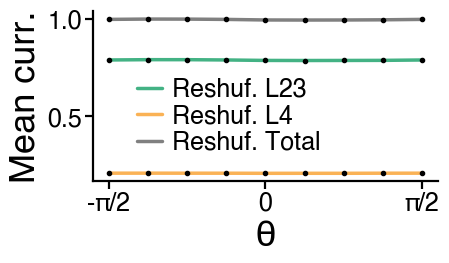

In [ ]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Reshuf. {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.1))

plt.xlabel('θ')
plt.ylabel('Mean curr.')
pic_name=f'{path2save}/modelcurrents_reshuffALL_L4.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

0.23431331378920173 0.1699662989639441


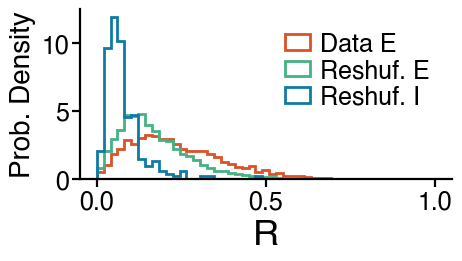

In [ ]:
bins = np.linspace(0,1,50)

cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), cved.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True, histtype='step', lw=2, label="Data E", color=cr.lcolor['L23'])
plt.hist(cved, bins=bins, density=True, histtype='step', lw=2, label="Reshuf. E", color=cr.lcolor['L23_modelE'])
plt.hist(cvid, bins=bins, density=True, histtype='step', lw=2, label="Reshuf. I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
if style=='poster':
    plt.ylabel("Prob. Density", fontsize=20)
else:
    plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelcirvar_reshuffleall_L4.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

In [ ]:
orionly= True
local_connectivity =False 

inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, stdre, units_sample = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='L4tuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scpint.quad(integrand, min, max)
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achiev

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


1.6706474129595197 1.4122687985660627
1.4698833218887826 1.4670380743447529


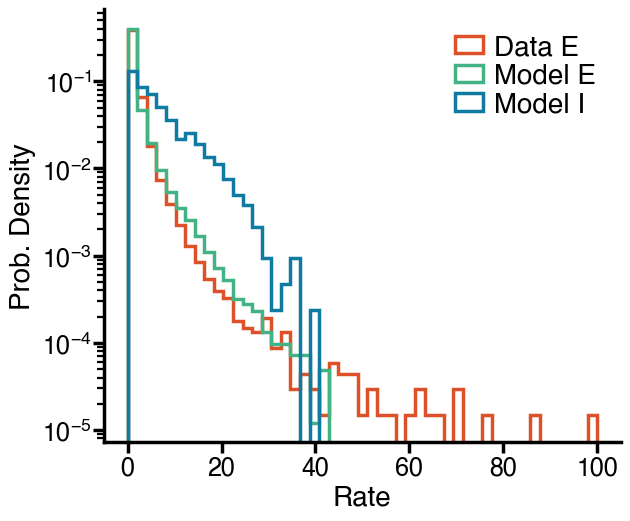

In [ ]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.xlabel('Rate')
plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_reshuffleL4_L4.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')

plt.show()


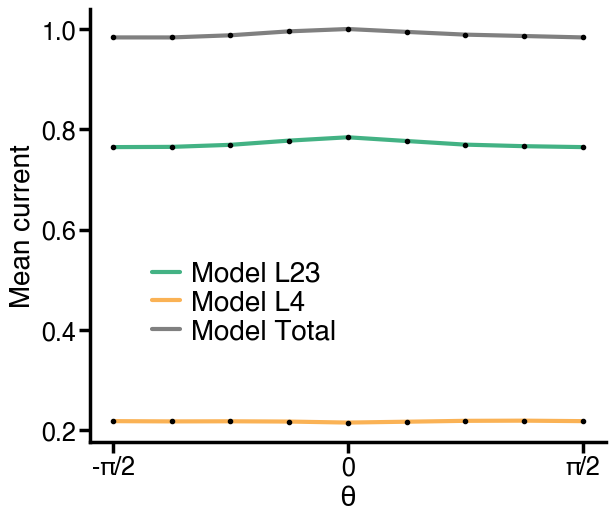

In [ ]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.2))

plt.xlabel('θ')
plt.ylabel('Mean current')
pic_name=f'{path2save}/modelcurrents_reshuffleL4_L4.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

0.23431331378920173 0.18074172408254557


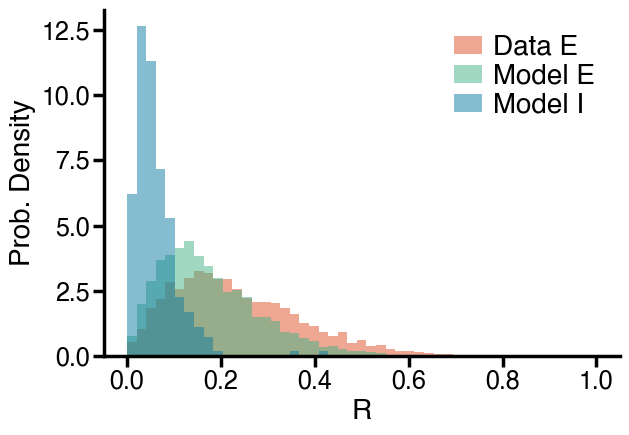

In [ ]:
bins = np.linspace(0,1,50)

cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), cved.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True, alpha=0.5, label="Data E", color=cr.lcolor['L23'])
plt.hist(cved, bins=bins, density=True, alpha=0.5, label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(cvid, bins=bins, density=True, alpha=0.5, label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelcirvar_reshuffleL4_L4.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

In [40]:
orionly= True
local_connectivity =False 

inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, stdre, units_sample = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='L23tuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scpint.quad(integrand, min, max)
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achiev

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


1.6706474129595197 1.4260887705969059
1.4698833218887826 1.4670380743447529


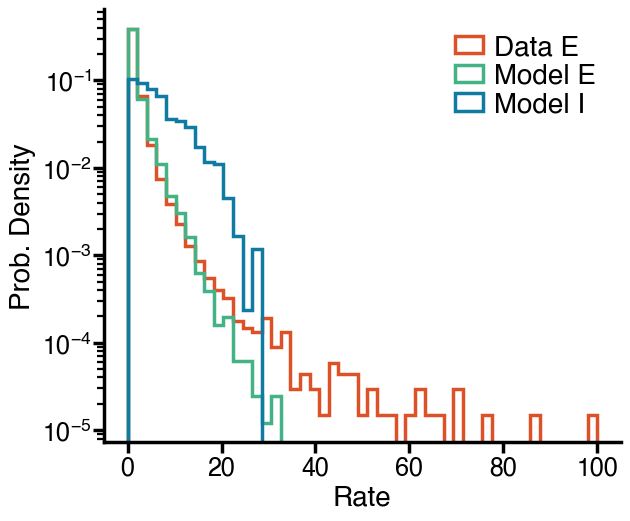

In [41]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.xlabel('Rate')
plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_reshuffleL23_L4.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')

plt.show()


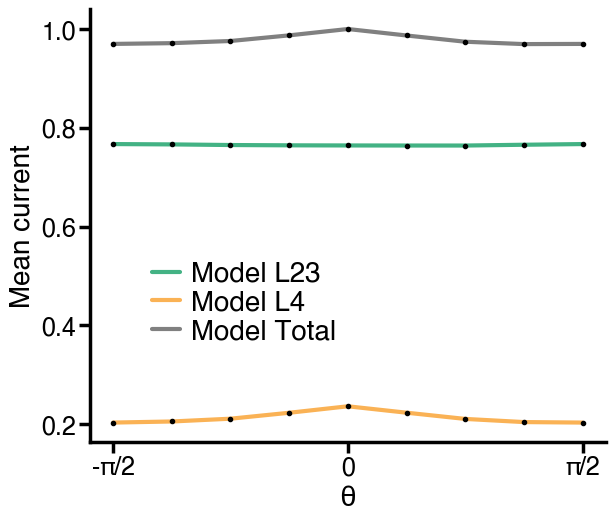

In [42]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.2))

plt.xlabel('θ')
plt.ylabel('Mean current')
pic_name=f'{path2save}/modelcurrents_reshuffleL23_L4.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

0.23431331378920173 0.15504630258215518


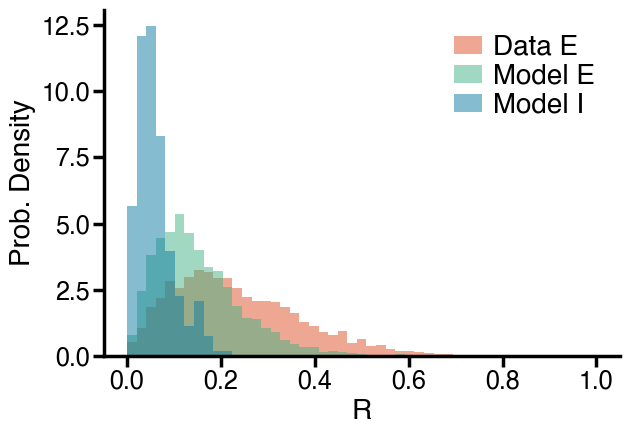

In [43]:
bins = np.linspace(0,1,50)

cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), cved.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True, alpha=0.5, label="Data E", color=cr.lcolor['L23'])
plt.hist(cved, bins=bins, density=True, alpha=0.5, label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(cvid, bins=bins, density=True, alpha=0.5, label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelcirvar_reshuffleL23_L4.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

# Do simulations using the data

In [ ]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
connections = fl.remove_autapses(connections)

ne, ni, nx = n_neurons

connections.loc[:, 'syn_volume'] /=  connections.loc[:, 'syn_volume'].mean()

l23exc = fl.filter_neurons(units, layer='L23', cell_type='exc') 
l23inh     = fl.filter_neurons(units, layer='L23', cell_type='inh')
l4neurons  = fl.filter_neurons(units, layer='L4', cell_type='exc', tuning='matched') 

Esample = np.random.choice(l23exc['id'], size=ne, replace=False)
Isample = np.random.choice(l23inh['id'], size=ni, replace=False)
Xsample = np.random.choice(l4neurons['id'], size=nx, replace=True)

ids_to_use_pre = np.hstack([Esample, Isample, Xsample])
ids_to_use_post = np.hstack([Esample, Isample])

vijdata = loader.get_adjacency_matrix(units, connections)
vijdata = vijdata[:, ids_to_use_pre]
vijdata = vijdata[ids_to_use_post, :]
vijdata.shape


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")
/tmp/ipykernel_6309/772530344.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.24530988 2.38714996 0.46813719 ... 3.6067048  1.62424121 0.74492268]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections.loc[:, 'syn_volume'] /=  connections.loc[:, 'syn_volume'].mean()


(5288, 7870)

In [ ]:
orionly= True
local_connectivity =False 

inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, stdre, units_sample = md.make_simulation_fixed_structure(400, 8000, vijdata, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='alltuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scpint.quad(integrand, min, max)
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achiev

1.6706474129595197 0.1849230968053345
1.4698833218887826 1.5292505237561484


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


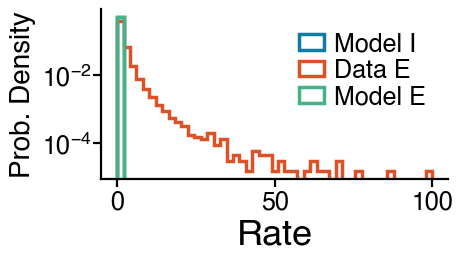

In [ ]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.xlabel('Rate')
if style=='poster':
    plt.ylabel('Prob. Density', fontsize=20)
else:
    plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_datamatrix.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)

plt.show()


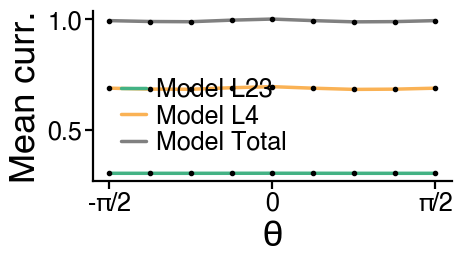

In [ ]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.05, 0.1))

plt.xlabel('θ')
plt.ylabel('Mean curr.')
pic_name=f'{path2save}/modelcurrents_datamatrix.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

# Simulation dominated by L23

It's the same code as above but variables are called slightly different so we can re-run without overwritting...

In [56]:
orionly= True
local_connectivity =False 
np.random.seed(274938221)
inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, rx, stdre, units_sample, connections_sample, QJ, n_neurons, original_tuned_ids, original_prefori = md.make_simulation(400, 8000, inferred[0], inferred[1],  theta=inferred[2], sigma_t=inferred[3], local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})



/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/matrixsampler.py:235: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  act_matrix[i,theta] = activity_L4.loc[i, theta]
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  th

1.6706474129595197 1.4585311768246125
1.4698833218887826 1.4880697157032194


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


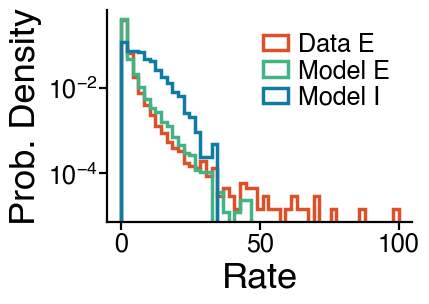

In [57]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.xlabel('Rate')
plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')

plt.show()


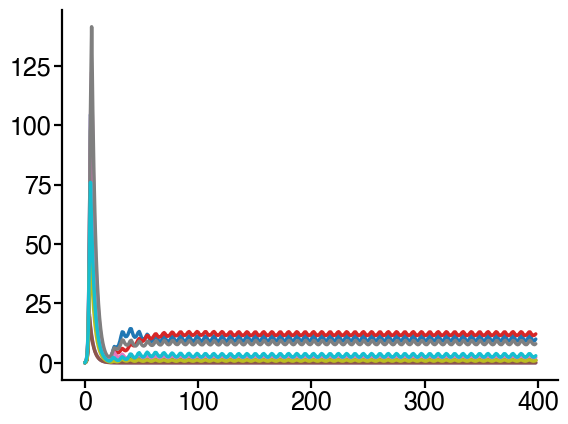

In [58]:
for i in range(10):
    plt.plot(aE_t[i, :])

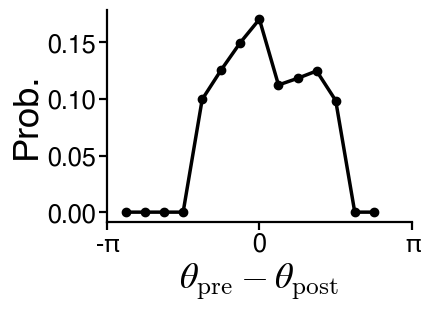

In [59]:
newpreforis = units_sample[units_sample['id'].isin(original_tuned_ids)] 
angledif = au.signed_angle_dist_vectorized(newpreforis['pref_ori'].values, original_prefori.values, half=True)

bins = np.arange(-7.5, 7.5, 1)
#bins = np.arange(-0.5, 16.5, 1)
hist, edges = np.histogram(angledif, bins=bins)
cedges = 0.5*(edges[1:]+edges[:-1])
figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
plt.plot(cedges, hist / hist.sum(), marker='o', color='black')
plt.xticks([-8,0,8], ['-π', '0', 'π'])
plt.xlabel(r"$θ_\text{pre} - θ_\text{post}$")
plt.ylabel("Prob.")
pic_name=f'{path2save}/angleschanged_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

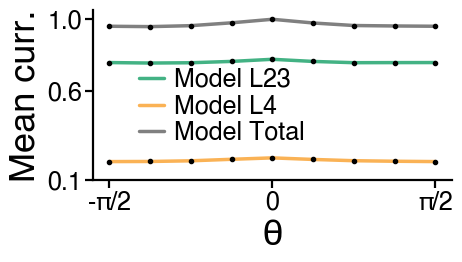

In [60]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.15))
plt.yticks([0.1, 0.6, 1])
plt.ylim(0.1, 1.05)

plt.xlabel('θ')
plt.ylabel('Mean curr.')
pic_name=f'{path2save}/modelcurrents_L23.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

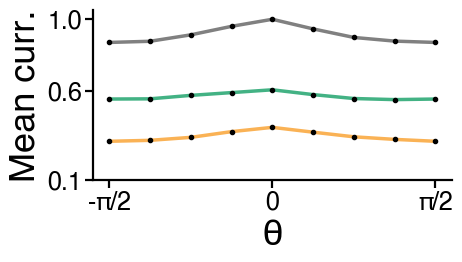

In [67]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['tuned', 'tuned'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])
totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=layer, color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.yticks([0.1, 0.6, 1])
plt.ylim(0.1, 1.05)

plt.xlabel('θ')
plt.ylabel('Mean curr.')

pic_name=f'{path2save}/modelcurrentstuned_L23.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)



0.45543251333955964


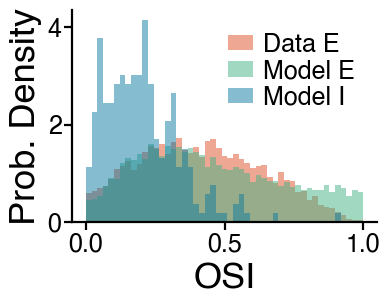

In [62]:
bins = np.linspace(0,1,50)

OSI_E = mutl.compute_orientation_selectivity_index(re)    
OSI_I = mutl.compute_orientation_selectivity_index(ri)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
osi_data = mutl.compute_orientation_selectivity_index(rates[units_e['id']])

print(OSI_E.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(osi_data, bins=bins, density=True, alpha=0.5, label="Data E", color=cr.lcolor['L23'])
plt.hist(OSI_E, bins=bins, density=True, alpha=0.5, label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(OSI_I, bins=bins, density=True, alpha=0.5, label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("OSI")
plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelosi_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

0.23431331378920173 0.26855389510248756


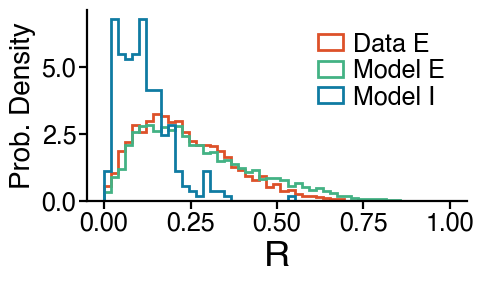

In [63]:
bins = np.linspace(0,1,50)

cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), cved.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([12., 6.9]))}
plt.figure(figsize=figsize[style], layout='constrained')
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True, lw=2, histtype='step', label="Data E", color=cr.lcolor['L23'])
plt.hist(cved, bins=bins, density=True, lw=2, histtype='step', label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(cvid, bins=bins, density=True, lw=2, histtype='step',label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
if style=='poster':
    plt.ylabel("Prob. Density", fontsize=20)
else:
    plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelcirvar_L23.pdf'
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

## Reshuffling experiments for this network 

In [92]:

orionly= True
local_connectivity =False 

inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, stdre, units_sample = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='alltuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scpint.quad(integrand, min, max)
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achiev

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


1.6706474129595197 1.5684847411117462
1.4698833218887826 1.4880697157032194


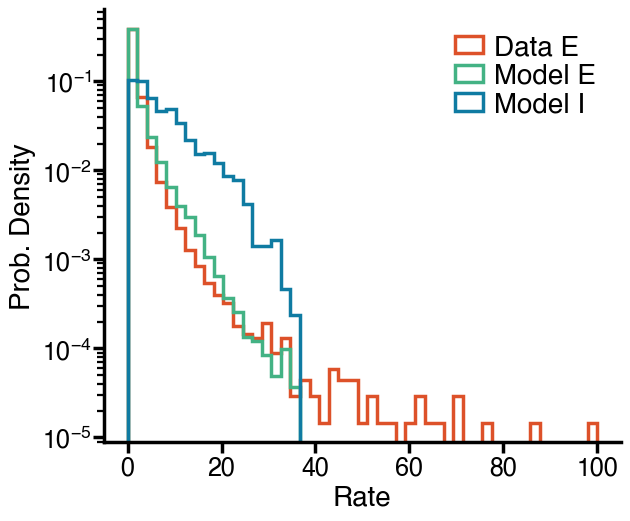

In [51]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.xlabel('Rate')
plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_reshuffleALL_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')

plt.show()


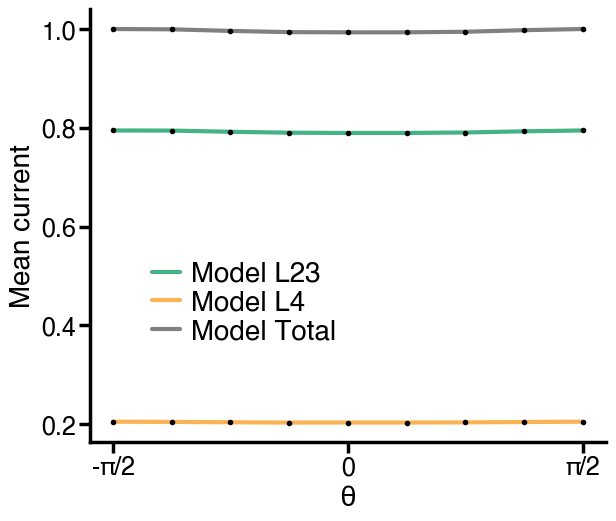

In [52]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.2))

plt.xlabel('θ')
plt.ylabel('Mean current')
pic_name=f'{path2save}/modelcurrents_reshuffleALL_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

0.23431331378920173 0.21061721957203097


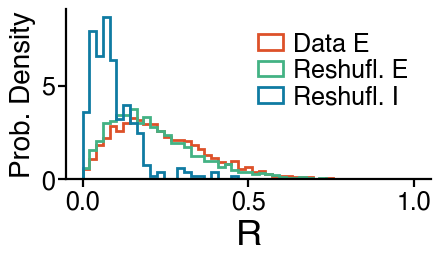

In [95]:
bins = np.linspace(0,1,50)

cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), cved.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True, lw=2, histtype='step', label="Data E", color=cr.lcolor['L23'])
plt.hist(cved, bins=bins, density=True, lw=2, histtype='step', label="Reshufl. E", color=cr.lcolor['L23_modelE'])
plt.hist(cvid, bins=bins, density=True, lw=2, histtype='step', label="Reshufl. I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
if style=='poster':
    plt.ylabel("Prob. Density", fontsize=20)
else:
    plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelcirvar_reshuffleALL_L23.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

In [54]:
orionly= True
local_connectivity =False 

inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, stdre, units_sample = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='L4tuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scpint.quad(integrand, min, max)
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achiev

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


1.6706474129595197 1.4792817223270756
1.4698833218887826 1.4880697157032194


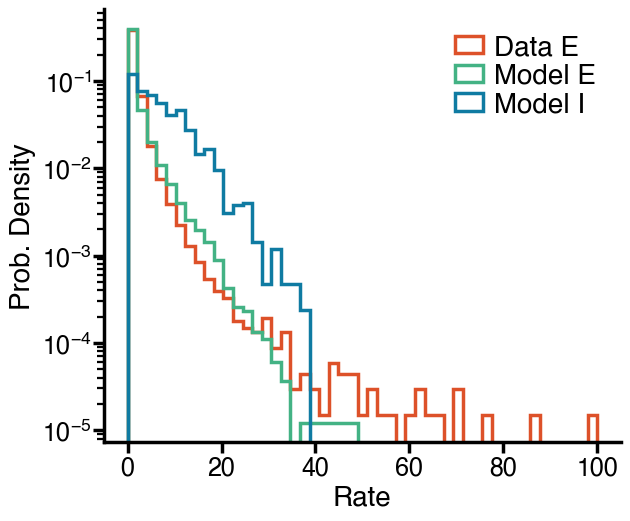

In [55]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.xlabel('Rate')
plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_reshuffleL4_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')

plt.show()


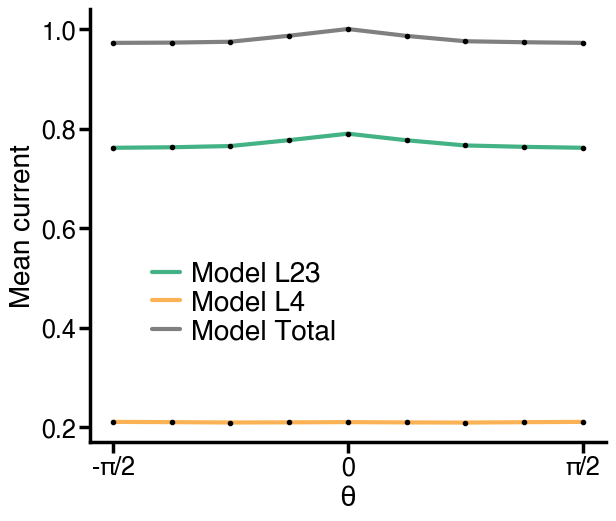

In [56]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.2))

plt.xlabel('θ')
plt.ylabel('Mean current')
pic_name=f'{path2save}/modelcurrents_reshuffleL4_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

0.23431331378920173 0.19829476185240696


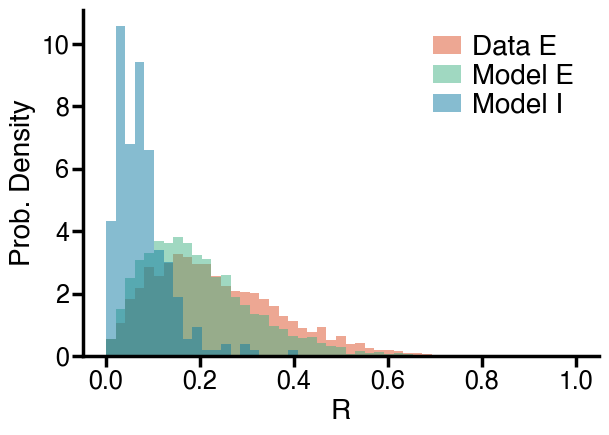

In [57]:
bins = np.linspace(0,1,50)

cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), cved.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True, alpha=0.5, label="Data E", color=cr.lcolor['L23'])
plt.hist(cved, bins=bins, density=True, alpha=0.5, label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(cvid, bins=bins, density=True, alpha=0.5, label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelcirvar_reshuffleL4_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

In [58]:
orionly= True
local_connectivity =False 

inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])
aE_t, re, ri, stdre, units_sample = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='L23tuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
units_sample = units_sample.rename(columns={'pt_root_id':'id'})
connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scpint.quad(integrand, min, max)
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achiev

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")


1.6706474129595197 1.5255352352156102
1.4698833218887826 1.4880697157032194


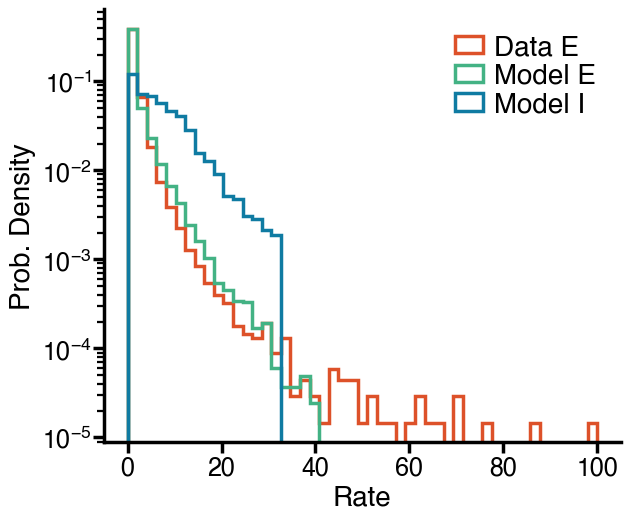

In [59]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]
l4  = units.loc[(units['layer']=='L4')&(units['tuning_type']!='not_matched'), 'id']
exprates4 = rates[l4, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), re.mean())
print(exprates4.mean(), rx.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(re.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.hist(ri.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.xlabel('Rate')
plt.ylabel('Prob. Density')
plt.yscale('log')
plt.legend()

pic_name=f'{path2save}/ratedist_reshuffleL23_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')

plt.show()


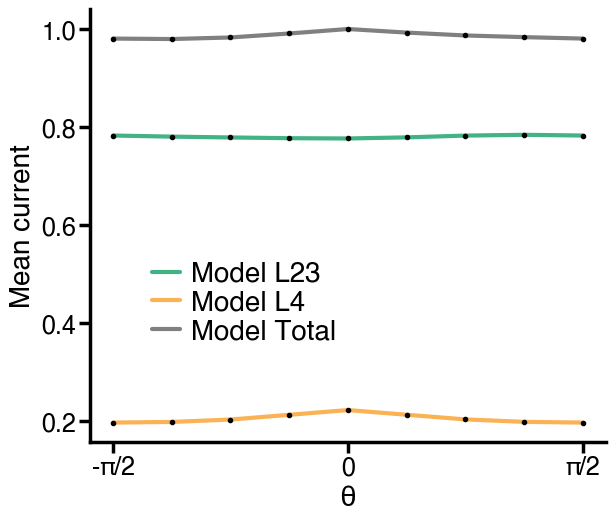

In [60]:
rates_sample = np.vstack([re, ri, rx])
currents = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])

totalmean = currents['Total'].mean(axis=0).max()
for layer in ['L23', 'L4', 'Total']:
    mean = plotutils.shift(currents[layer].mean(axis=0)/totalmean)
    std = plotutils.shift(currents[layer].std(axis=0)/totalmean)
    plt.plot(mean, label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean,  color='black', ls='none', marker='.')
    #plt.fill_between(np.arange(9), mean-std, mean+std, alpha=0.2, color=cr.lcolor[layer])
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.2))

plt.xlabel('θ')
plt.ylabel('Mean current')
pic_name=f'{path2save}/modelcurrents_reshuffleL23_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

0.23431331378920173 0.2139483643186487


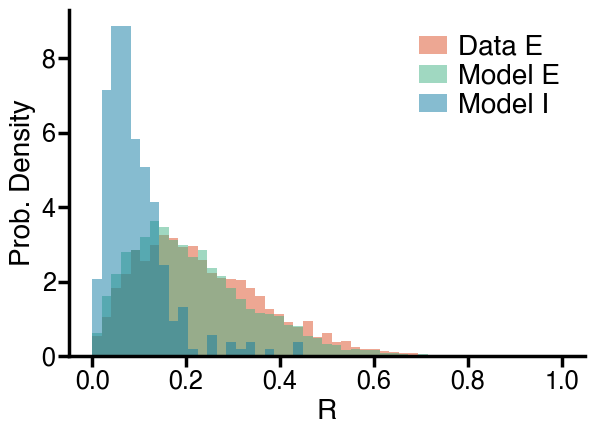

In [61]:
bins = np.linspace(0,1,50)

cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), cved.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True, alpha=0.5, label="Data E", color=cr.lcolor['L23'])
plt.hist(cved, bins=bins, density=True, alpha=0.5, label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(cvid, bins=bins, density=True, alpha=0.5, label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelcirvar_reshuffleL23_L23.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

# Averages over the quenched disorder

In [70]:
orionly= True
local_connectivity =False 
inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])

nrepetitions = 10 
dist_re = np.empty(0) 
dist_ri = np.empty(0)
dist_osi_e = np.empty(0) 
dist_osi_i = np.empty(0) 
dist_cv_e = np.empty(0) 
dist_cv_i = np.empty(0) 

mean_curr_matched = {'L23':np.zeros(9), 'L4':np.zeros(9), 'Total':np.zeros(9)}
mean_curr_tuned = {'L23':np.zeros(9), 'L4':np.zeros(9), 'Total':np.zeros(9)}

for rep in range(nrepetitions):
    aE_t, re, ri, rx, stdre, units_sample, connections_sample, QJ, n_neurons, original_tuned_ids, original_prefori = md.make_simulation(400, 8000, inferred[0], inferred[1],  theta=inferred[2], sigma_t=inferred[3], local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
    units_sample = units_sample.rename(columns={'pt_root_id':'id'})
    connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})

    dist_re = np.concatenate([dist_re, re.ravel()])
    dist_ri = np.concatenate([dist_ri, ri.ravel()])

    OSI_E = mutl.compute_orientation_selectivity_index(re)    
    OSI_I = mutl.compute_orientation_selectivity_index(ri)    

    dist_osi_e = np.concatenate([dist_osi_e, OSI_E])
    dist_osi_i = np.concatenate([dist_osi_i, OSI_I])

    cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
    cvio, cvid = mutl.compute_circular_variance(ri, orionly=True)    

    dist_cv_e  = np.concatenate([dist_cv_e, cved])
    dist_cv_i  = np.concatenate([dist_cv_i, cvid])

    rates_sample = np.vstack([re, ri, rx])
    currents_matched = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['matched', 'matched'], cell_type=['exc', 'exc'])
    currents_tuned = mcur.bootstrap_mean_current(units_sample, QJ, rates_sample, tuning=['tuned', 'tuned'], cell_type=['exc', 'exc'])

    for layer in ['L23', 'L4', 'Total']:
        mean = plotutils.shift(currents_matched[layer].mean(axis=0))
        mean_curr_matched[layer] += mean

        mean = plotutils.shift(currents_tuned[layer].mean(axis=0))
        mean_curr_tuned[layer] += mean



for layer in ['L23', 'L4']:
    mean_curr_matched[layer] /= nrepetitions 
    mean_curr_tuned[layer] /= nrepetitions 

mean_curr_matched['Total'] = mean_curr_matched['L23'] + mean_curr_matched['L4']
mean_curr_tuned['Total'] = mean_curr_tuned['L23'] + mean_curr_tuned['L4']

totalmaxmatched = mean_curr_matched['Total'].max()
totalmaxtuned = mean_curr_tuned['Total'].max()
print(totalmaxmatched)
for layer in ['L23', 'L4', 'Total']:
    mean_curr_matched[layer] /= totalmaxmatched 
    mean_curr_tuned[layer] /= totalmaxtuned 


    

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/matrixsampler.py:235: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  act_matrix[i,theta] = activity_L4.loc[i, theta]
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  th

1173.686001058787


In [75]:
np.save('../../ccmodels/victor/distcve', dist_cv_e)
np.save('../../ccmodels/victor/distcvi', dist_cv_i)
np.save('../../ccmodels/victor/distosie', dist_osi_e)
np.save('../../ccmodels/victor/distosii', dist_osi_i)
np.save('../../ccmodels/victor/distre', dist_re)
np.save('../../ccmodels/victor/distri', dist_ri)
np.save('../../ccmodels/victor/currentmatched', mean_curr_matched, allow_pickle=True)
np.save('../../ccmodels/victor/currenttuned', mean_curr_tuned, allow_pickle=True)

In [75]:
dist_cv_e = np.load('../../ccmodels/victor/distcve.npy')
dist_cv_i = np.load('../../ccmodels/victor/distcvi.npy')
dist_osi_e = np.load('../../ccmodels/victor/distosie.npy')
dist_osi_i = np.load('../../ccmodels/victor/distosii.npy')
dist_re = np.load('../../ccmodels/victor/distre.npy')
dist_ri = np.load('../../ccmodels/victor/distri.npy')
currents_matched = np.load('../../ccmodels/victor/currentmatched.npy', allow_pickle=True)
currents_tuned  = np.load('../../ccmodels/victor/currenttuned.npy', allow_pickle=True)

/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/dataanalysis/processedloader.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    2,    6,    0,    3,    2,    0,    0,    3,    1,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 17412, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  v1_neurons.loc[:, "pref_ori"] = v1_neurons["pref_ori"].astype("Int64")
/tmp/ipykernel_4998/777449466.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-5, 0)


1.6706474129595197 1.4234407472500226


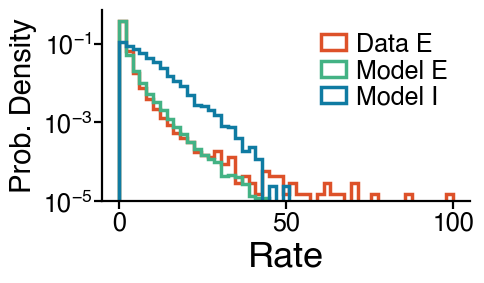

In [79]:
units, connections, rates = loader.load_data(prepath='../../data', orientation_only=True)
l23 = units.loc[(units['layer']=='L23')&(units['tuning_type']!='not_matched'), 'id']
exprates23 = rates[l23, :]

bins = np.linspace(0, 100, 50)

print(exprates23.mean(), dist_re.mean())

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style], layout='constrained')

plt.hist(exprates23.ravel(), density=True,  histtype='step', lw=2.5, bins=bins, label='Data E', color=cr.lcolor['L23'])
plt.hist(dist_re, density=True,  histtype='step', lw=2.5, bins=bins, label='Model E', color=cr.lcolor['L23_modelE'])
plt.hist(dist_ri, density=True,  histtype='step', lw=2.5, bins=bins, label='Model I', color=cr.lcolor['L23_modelI'])
plt.xlabel('Rate')
plt.ylabel('Prob. Density', fontsize=21)
plt.yscale('log')
plt.ylim(1e-5, 0)
plt.legend()

pic_name=f'{path2save}/ratedist_avgquenched.pdf'
plt.savefig(pic_name,format='pdf',transparent=True)
plt.show()


In [77]:
rates_sample = np.vstack([re, ri, rx])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])

for layer in ['L23', 'L4', 'Total']:
    plt.plot(mean_curr_matched[layer], label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean_curr_matched[layer],  color='black', ls='none', marker='.')
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.1, 0.2))

#plt.plot(mean_curr_matched['L23']+mean_curr_matched['L4'])

plt.xlabel('θ')
plt.ylabel('Mean current')
pic_name=f'{path2save}/modelcurrents_avgquenched.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

NameError: name 'mean_curr_matched' is not defined

<Figure size 393.701x275.591 with 0 Axes>

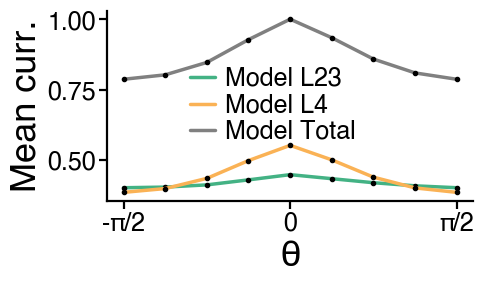

In [ ]:

rates_sample = np.vstack([re, ri, rx])

figsize = {'slides':sty.slide_size(0.5, 0.75, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style], layout='constrained')

for layer in ['L23', 'L4', 'Total']:
    plt.plot(mean_curr_tuned[layer], label=f'Model {layer}', color=cr.lcolor[f'{layer}_modelE'])
    plt.plot(mean_curr_tuned[layer],  color='black', ls='none', marker='.')
plt.xticks([0,4,8], ['-π/2', '0', 'π/2'])
plt.legend(loc = (0.2, 0.25))

plt.xlabel('θ')
plt.ylabel('Mean curr.')
pic_name=f'{path2save}/modelcurrentstuned_avgquenched.pdf'
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

0.2929081969482212


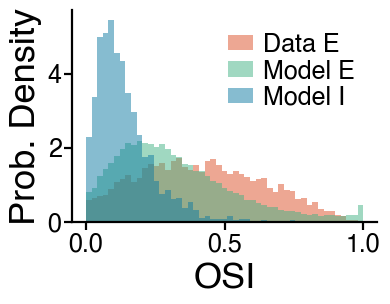

In [ ]:
bins = np.linspace(0,1,50)

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
osi_data = mutl.compute_orientation_selectivity_index(rates[units_e['id']])

print(OSI_E.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([10, 7]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(osi_data, bins=bins, density=True, alpha=0.5, label="Data E", color=cr.lcolor['L23'])
plt.hist(dist_osi_e, bins=bins, density=True, alpha=0.5, label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(dist_osi_i, bins=bins, density=True, alpha=0.5, label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("OSI")
plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelosi_avgquenched.pdf'
plt.savefig(pic_name,format='pdf',bbox_inches='tight')
plt.show()

0.23431331378920173 0.18973001795868683


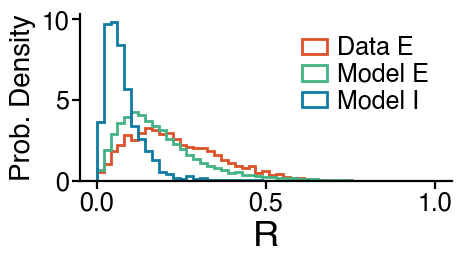

In [80]:
bins = np.linspace(0,1,50)

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

print(cv_data.mean(), dist_cv_e.mean())

figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style])
#plt.title(f"J={J_values[best_ix[0]-5]:.2f}, g={g_values[best_ix[1]]:.2f}")
plt.hist(cv_data, bins=bins, density=True,   lw=2, histtype='step', label="Data E", color=cr.lcolor['L23'])
plt.hist(dist_cv_e, bins=bins, density=True, lw=2, histtype='step', label="Model E", color=cr.lcolor['L23_modelE'])
plt.hist(dist_cv_i, bins=bins, density=True, lw=2, histtype='step', label="Model I", color=cr.lcolor['L23_modelI'])
plt.xlabel("R")
if style=='poster':
    plt.ylabel("Prob. Density", fontsize=20)
else: 
    plt.ylabel("Prob. Density")
plt.legend()
pic_name=f'{path2save}/modelcirvar_avgquenched.pdf'
plt.tight_layout()
plt.savefig(pic_name,format='pdf', transparent=True)
plt.show()

## Do experiments on tuning for reshuffling + quenched disorder cases

In [62]:
orionly= True
local_connectivity =False 
inferred = np.array([ 1.56406406,  1.34534535, 21.04354354,  8.57907908])

nrepetitions = 10 
dist_cv_e_full = np.empty(0) 
dist_cv_e_rL23 = np.empty(0) 
dist_cv_e_rL4  = np.empty(0) 
dist_cv_e_rall = np.empty(0) 

avfull, stdfull = (0., 0.)
avl4, stdl4 = (0., 0.)
avl23, stdl23 = (0., 0.)
avlall, stdlall = (0., 0.)

mean_curr_matched = {'L23':np.zeros(9), 'L4':np.zeros(9), 'Total':np.zeros(9)}
mean_curr_tuned = {'L23':np.zeros(9), 'L4':np.zeros(9), 'Total':np.zeros(9)}

for rep in range(nrepetitions):
    aE_t, re, ri, rx, stdre, units_sample, connections_sample, QJ, n_neurons, original_tuned_ids, original_prefori = md.make_simulation(400, 8000, inferred[0], inferred[1],  theta=inferred[2], sigma_t=inferred[3], local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
    units_sample = units_sample.rename(columns={'pt_root_id':'id'})
    connections_sample = connections_sample.rename(columns={'pre_pt_root_id':'pre_id', 'post_pt_root_id':'post_id'})

    cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
    #dist_cv_e_full  = np.concatenate([dist_cv_e, cved])
    m = cved.mean()
    avfull += m 
    stdfull += m*m 

    aE_t, re, ri, stdre, units_sample_r = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='L4tuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
    cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
    #dist_cv_e_rL4  = np.concatenate([dist_cv_e_rL4, cved])
    m = cved.mean()
    avl4 += m 
    stdl4 += m*m 

    aE_t, re, ri, stdre, units_sample_r = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='L23tuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
    cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
    #dist_cv_e_rL23  = np.concatenate([dist_cv_e_rL23, cved])
    m = cved.mean()
    avl23 += m 
    stdl23 += m*m 

    aE_t, re, ri, stdre, units_sample_r = md.make_simulation_fixed_structure(400, 8000, QJ, rx, n_neurons,  theta=inferred[2], sigma_t=inferred[3], reshuffle='alltuned', local_connectivity=local_connectivity, orionly=orionly, prepath='../../data')
    cveo, cved = mutl.compute_circular_variance(re, orionly=True)    
    #dist_cv_e_rall  = np.concatenate([dist_cv_e_rall, cved])
    m = cved.mean()
    avlall += m 
    stdlall += m*m


avfull /= nrepetitions
stdfull /= nrepetitions
avl4 /= nrepetitions
stdl4 /= nrepetitions
avl23 /= nrepetitions
stdl23 /= nrepetitions
avlall /= nrepetitions
stdlall /= nrepetitions


/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/alessandro_extractstats.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21266713 2.06949806 0.40584338 ... 3.12676988 1.40810762 0.64579774]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connections_table.loc[:,'syn_volume']=connections_table.loc[:,'syn_volume']/norm_V
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/matrixsampler.py:235: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  act_matrix[i,theta] = activity_L4.loc[i, theta]
/home/victor/Fisica/Research/Milan/con-con-models/scripts/figures/../.././ccmodels/modelanalysis/utils.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  th

In [63]:
avs = np.array([avfull, avl4, avl23, avlall])
stds = np.array([stdfull, stdl4, stdl23, stdlall])
np.save('../../ccmodels/victor/avg', avs)
np.save('../../ccmodels/victor/std', stds)

In [42]:
avs = np.load('../../ccmodels/victor/avg.npy')
stds = np.load('../../ccmodels/victor/std.npy')
avs = np.concatenate([[cv_data.mean()], avs])
stds = np.concatenate([[0], stds])

avs.shape, stds.shape

((5,), (5,))

/tmp/ipykernel_4998/1570500587.py:9: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(np.arange(len(avs)), avs, yerr=np.sqrt(stds-avs*avs), color='black', ls='none')


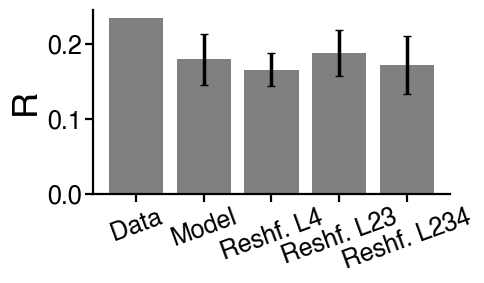

In [44]:
figsize = {'slides':sty.slide_size(0.5, 0.6, software), 'poster':sty.to_inches(np.array([12, 6.9]))}
plt.figure(figsize=figsize[style], layout='constrained')

units_e = fl.filter_neurons(units, layer='L23', tuning='matched', cell_type='exc')
_, cv_data = mutl.compute_circular_variance(rates[units_e['id']], orionly=True)

plt.bar(['Data', "Model", 'Reshf. L4', 'Reshf. L23', 'Reshf. L234'], avs, color='gray')
plt.xticks(rotation=20)
plt.errorbar(np.arange(len(avs)), avs, yerr=np.sqrt(stds-avs*avs), color='black', ls='none')
plt.ylabel("R")

pic_name=f'{path2save}/comparisoncircvar.pdf'
plt.savefig(pic_name,format='pdf', transparent=True)